<a href="https://colab.research.google.com/github/Janina712/MLTSA_FinalProject/blob/main/tryouts/Random_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pickle5

     |████████████████████████████████| 256 kB 4.3 MB/s 


In [90]:
import pandas as pd
import numpy as np
import pickle5 as pickle
from pathlib import Path
import pylab as pl
from scipy import stats 
from scipy.stats import linregress
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from tensorflow import keras
from keras import layers 
from keras.layers import Dense, Input, Flatten,\
                   Reshape, LeakyReLU as LR,\
                   Activation, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras import backend as K


%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/MLTSA22/Final_Project

/content/drive/MyDrive/MLTSA22/Final_Project


In [ ]:
!ls /content/drive/MyDrive/MLTSA22/Final_Project

00000258_s002_t000.edf
00010563_s002_t004.pkl
all_tuh_eeg_seizure_links.txt
curated_features_w_metadata_df.pkl
dev__01_tcp_ar__002__00000258__s002_2003_07_21__00000258_s002_t000.edf
dev__01_tcp_ar__002__00000258__s003_2003_07_22__00000258_s003_t001.edf
eval_balanced.pkl
eval.pkl
files_raw_channels_small_df.pkl
isip_tuh_eeg
seizures_types_v01.xlsx
temp
test_balanced.pkl
test.pkl
train_balanced.pkl
train.csv
train.pkl


In [ ]:
working_folder = Path('/content/drive/MyDrive/MLTSA22/Final_Project/')

In [ ]:
with open(working_folder.joinpath('train_balanced.pkl'), "rb") as fh:
  train = pickle.load(fh)

In [ ]:
with open(working_folder.joinpath('test_balanced.pkl'), "rb") as fh:
  test = pickle.load(fh)

In [ ]:
with open(working_folder.joinpath('eval_balanced.pkl'), "rb") as fh:
  eval = pickle.load(fh)

In [ ]:
train_features, train_labels = train.loc[:, train.columns != 'label'], train['label']
test_features, test_labels = test.loc[:, test.columns != 'label'], test['label']
eval_features, eval_labels = eval.loc[:, eval.columns != 'label'], eval['label']

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
print('Validation Features Shape:', eval_features.shape)
print('Validation Labels Shape:', eval_labels.shape)

Training Features Shape: (106336, 336)
Training Labels Shape: (106336,)
Testing Features Shape: (54210, 336)
Testing Labels Shape: (54210,)
Validation Features Shape: (35828, 336)
Validation Labels Shape: (35828,)


In [ ]:
# Instantiate model with 1000 decision trees
# n_estimators = 100 standard, won't cause overfitting but increases complexity
# max_depth - really important for accuracy, causes overfitiing
# We generally keep min_samples_split value between 2 and 6
# min_samples_leaf: less - overfitting, more - decreased number of parameters, basic - 1
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, min_samples_leaf = 3)
# Train the model on training data
rf.fit(train_features, train_labels);

In [21]:
# Use the forest's predict method on the test data
predictions = rf.predict(eval_features)

In [22]:
train_score = rf.score(train_features, train_labels)
eval_score = rf.score(eval_features, eval_labels)

In [40]:
print('During training, the accuracy score was ' + str(round(train_score, 3)))
print('During validation, the accuracy score was ' + str(round(eval_score, 3)))

During training, the accuracy score was 0.999
During validation, the accuracy score was 0.641


In [30]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(train.columns[:-1], importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable:                   11 Importance: 0.01
Variable:                   12 Importance: 0.01
Variable:                   13 Importance: 0.01
Variable:                   27 Importance: 0.01
Variable:                   28 Importance: 0.01
Variable:                   29 Importance: 0.01
Variable:                   43 Importance: 0.01
Variable:                   59 Importance: 0.01
Variable:                   75 Importance: 0.01
Variable:                   91 Importance: 0.01
Variable:                  107 Importance: 0.01
Variable:                  123 Importance: 0.01
Variable:                  139 Importance: 0.01
Variable:                  155 Importance: 0.01
Variable:                  157 Importance: 0.01
Variable:                  171 Importance: 0.01
Variable:                  172 Importance: 0.01
Variable:                  173 Importance: 0.01
Variable:                  175 Importance: 0.01
Variable:                  187 Importance: 0.01
Variable:                  188 Importanc

In [34]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = train.columns[:-1], rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [35]:
cf_matrix = confusion_matrix(eval_labels, predictions)

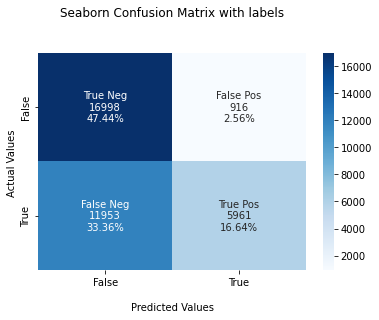

In [39]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
pl.show()

# Round 2

In [ ]:
with open(working_folder.joinpath('eval_balanced.pkl'), "rb") as fh:
  eval = pickle.load(fh)

In [ ]:
eval_features_notbalanced, eval_labels_notbalanced = eval.loc[:, eval.columns != 'label'], eval['label']

In [83]:
remove_n = round(int(train.shape[0]/3)) + 10000
drop_indices_False = np.random.choice(
    train[train['label'] == False].index, remove_n, replace=False
)
drop_indices_True = np.random.choice(
    train[train['label'] == True].index, remove_n, replace=False
)
train_subset = train.drop(drop_indices_False)
train_subset = train_subset.drop(drop_indices_True)

In [84]:
remove_n

45445

In [85]:
train_subset.shape

(15446, 337)

In [86]:
train_s_features, train_s_labels = train_subset.loc[:, train_subset.columns != 'label'], train_subset['label']

In [87]:
train_s_features.shape

(15446, 336)

In [ ]:
# Instantiate model with 1000 decision trees
# n_estimators = 100 standard, won't cause overfitting but increases complexity
# max_depth - really important for accuracy, causes overfitiing
# We generally keep min_samples_split value between 2 and 6
# min_samples_leaf: less - overfitting, more - decreased number of parameters, basic - 1
rf1 = RandomForestClassifier(
    n_estimators = 500, random_state = 42, min_samples_leaf = 2, min_samples_split = 3
)
# Train the model on training data
rf1.fit(train_s_features, train_s_labels);

In [94]:
predictions1 = rf1.predict(eval_features)

In [95]:
train_score1 = rf1.score(train_s_features, train_s_labels)
eval_score1 = rf1.score(eval_features, eval_labels)

In [96]:
print('During training, the accuracy score was ' + str(round(train_score1, 3)))
print('During validation, the accuracy score was ' + str(round(eval_score1, 3)))

During training, the accuracy score was 1.0
During validation, the accuracy score was 0.654


In [97]:
print(classification_report(eval_labels, predictions1))

              precision    recall  f1-score   support

       False       0.60      0.91      0.72     17914
        True       0.81      0.40      0.54     17914

    accuracy                           0.65     35828
   macro avg       0.71      0.65      0.63     35828
weighted avg       0.71      0.65      0.63     35828



In [92]:
accuracy_score(eval_labels, predictions1)

0.6594004689070001

In [ ]:
cf_matrix1 = confusion_matrix(eval_labels, predictions1)

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix1.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix1.flatten()/np.sum(cf_matrix1)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix1, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
pl.show()